In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("{} rows and {} columns".format(train.shape[0], train.shape[1]))

#We also split the dataset between the target variable (SalePrice) and the explanatory variables

target = train["SalePrice"]
train.drop(["SalePrice"], axis=1, inplace=True)
train.head(50)

1460 rows and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [3]:
#First, let's check if there is any missing data for each row/column 

train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

In [4]:
#We will now encode the object columns 

le = LabelEncoder()

categorical = []
error = []

for i in train.columns:
    if train[i].dtypes=="O":
        categorical.append(i)
        
for i in range(0, len(categorical)):
        if train[categorical[i]].isna().sum() > 0:
            error.append(categorical[i])

In [5]:
#On va maintenant consrtuire un pipeline pour traiter les données

def clean_data(X):
    le = LabelEncoder()
    categorical = []
    error = []
    missing = X[X.isna().sum()[X.isna().sum()>0].index].dtypes[X[X.isna().sum()[X.isna().sum()>0].index].dtypes=="float64"].index
    for col in missing:
        X[col] = X[col].fillna(np.mean(train[col]))
    for i in X.columns:
        if X[i].dtypes=="O":
            categorical.append(i)
    for i in range(0, len(categorical)):
        if X[categorical[i]].isna().sum() == 0:
            X[categorical[i]] = le.fit_transform(X[categorical[i]])
        else:
            error.append(categorical[i])
    X[error] = X[error].fillna("No such thing")
    for i in range(0, len(error)):
        X[error][i] = le.fit_transform(X[error][i])
    return X

def get_estimator():
    data_cleaner = FunctionTransformer(clean_data)
    model = XGBRegressor(n_estimators=2500, colsample_bytree=0.6, gamma=9, max_depth=4, min_child_weight=1, subsample=0.8, learning_rate=0.029)
    return make_pipeline(data_cleaner, model)

In [7]:
clean_data(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,0,3,4,1,0,2,2008,8,4
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,0,3,4,1,0,5,2007,8,4
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,0,3,4,1,0,9,2008,8,4
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,0,3,4,1,0,2,2006,8,0
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,...,0,0,3,4,1,0,8,2007,8,4
1456,1457,20,3,85.0,13175,1,1,3,3,0,...,0,0,3,2,1,0,2,2010,8,4
1457,1458,70,3,66.0,9042,1,1,3,3,0,...,0,0,3,0,3,2500,5,2010,8,4
1458,1459,20,3,68.0,9717,1,1,3,3,0,...,0,0,3,4,1,0,4,2010,8,4


In [9]:
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import VotingRegressor

X_train = train 
Y_train = target
X_test = test 
Y_test = pd.read_csv("sample_submission.csv")["SalePrice"]
X_test = clean_data(X_test)

#model_cat = CatBoostRegressor()
model_xgb = XGBRegressor(n_estimators=2500, colsample_bytree=0.6, gamma=9, max_depth=4, min_child_weight=1, subsample=0.8, learning_rate=0.029)
#model_mlp = MLPRegressor(max_iter=500)
#model_lgbm = lgb.LGBMRegressor(boosting="dart")
#model_3 = RandomForestRegressor(n_estimators=5000)

#model = VotingRegressor([('Cat', model_cat), ("xgb", model_xgb)], weights=[2/3, 1/3])
model_xgb.fit(X_train, Y_train)
#pipeline = get_estimator()
#pipeline.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=9, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.029, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
from sklearn.metrics import mean_squared_error

mean_squared_error(model_xgb.predict(X_test), Y_test)

5472373603.519127

In [12]:
model_xgb.predict(X_test)

array([127306.94, 163000.92, 185499.44, ..., 153462.58, 112750.61,
       220592.67], dtype=float32)

In [ ]:
#On optimise les hyperparamètres

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8]
        }

grid_search_rf = GridSearchCV(XGBRegressor(n_estimators=2000, learning_rate=0.029), params, cv=5)
grid_search_rf.fit(X_train, Y_train)

In [19]:
grid_search_rf.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

In [46]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': model.predict(X_test)})
my_submission.to_csv('submission.csv', index=False)

In [21]:
np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5))

0.8970305209870361

In [22]:
X_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [25]:
model.predict(X_test)

array([186790.56299859, 250943.14859946, 250024.00903465, ...,
       223375.77534826, 197298.27944799, 322465.3438961 ])

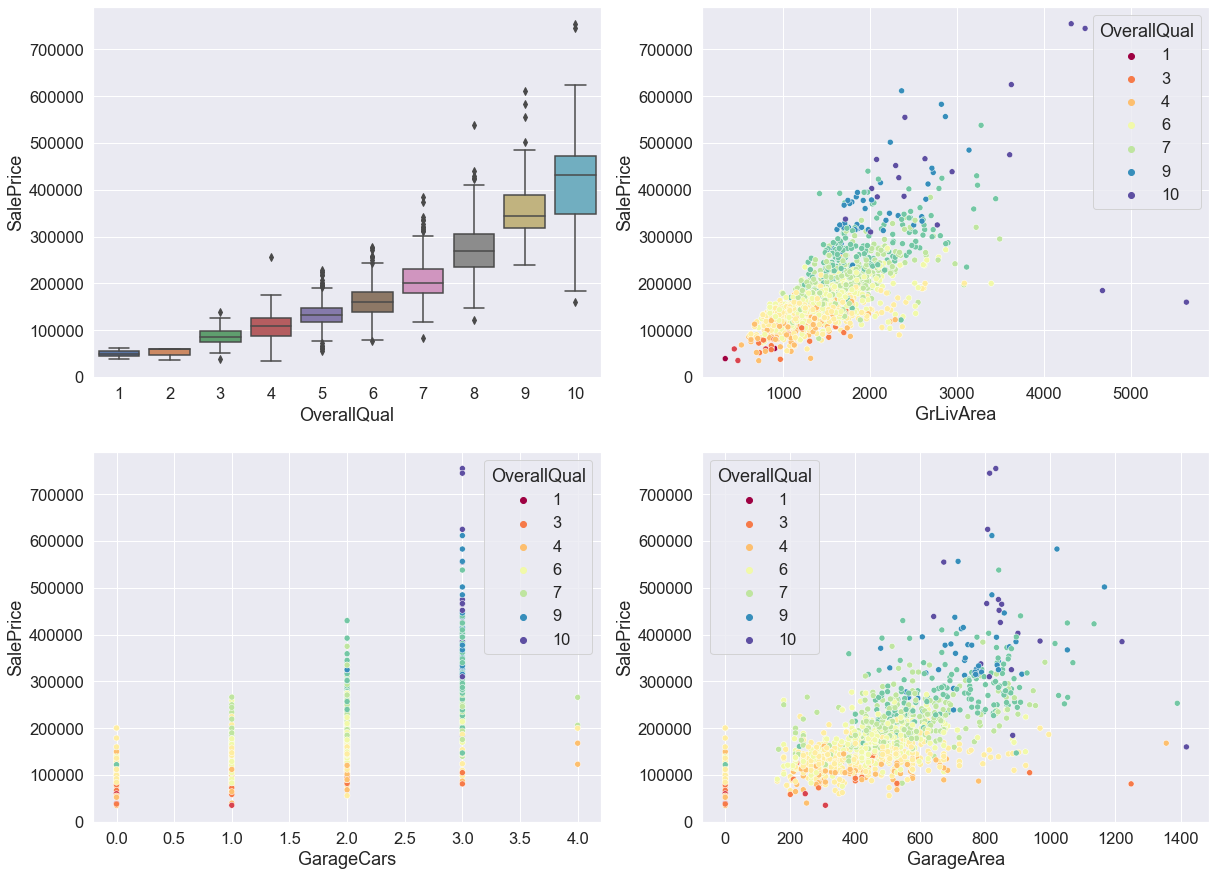

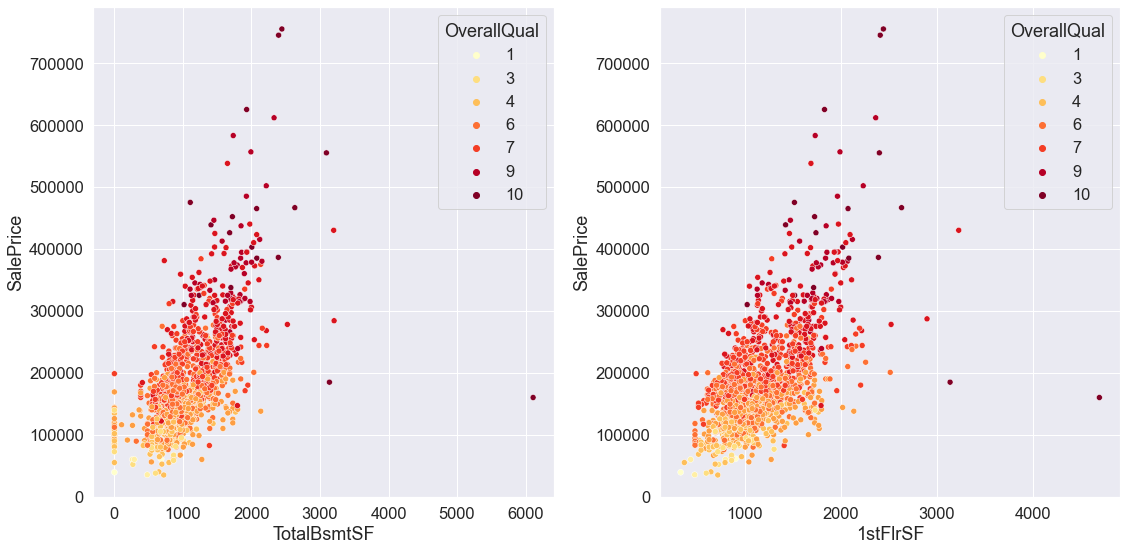

In [27]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

# (Corr= 0.700927) GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.680625) GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.650888) GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'YlOrRd')

fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'YlOrRd')

plt.tight_layout(); plt.show()

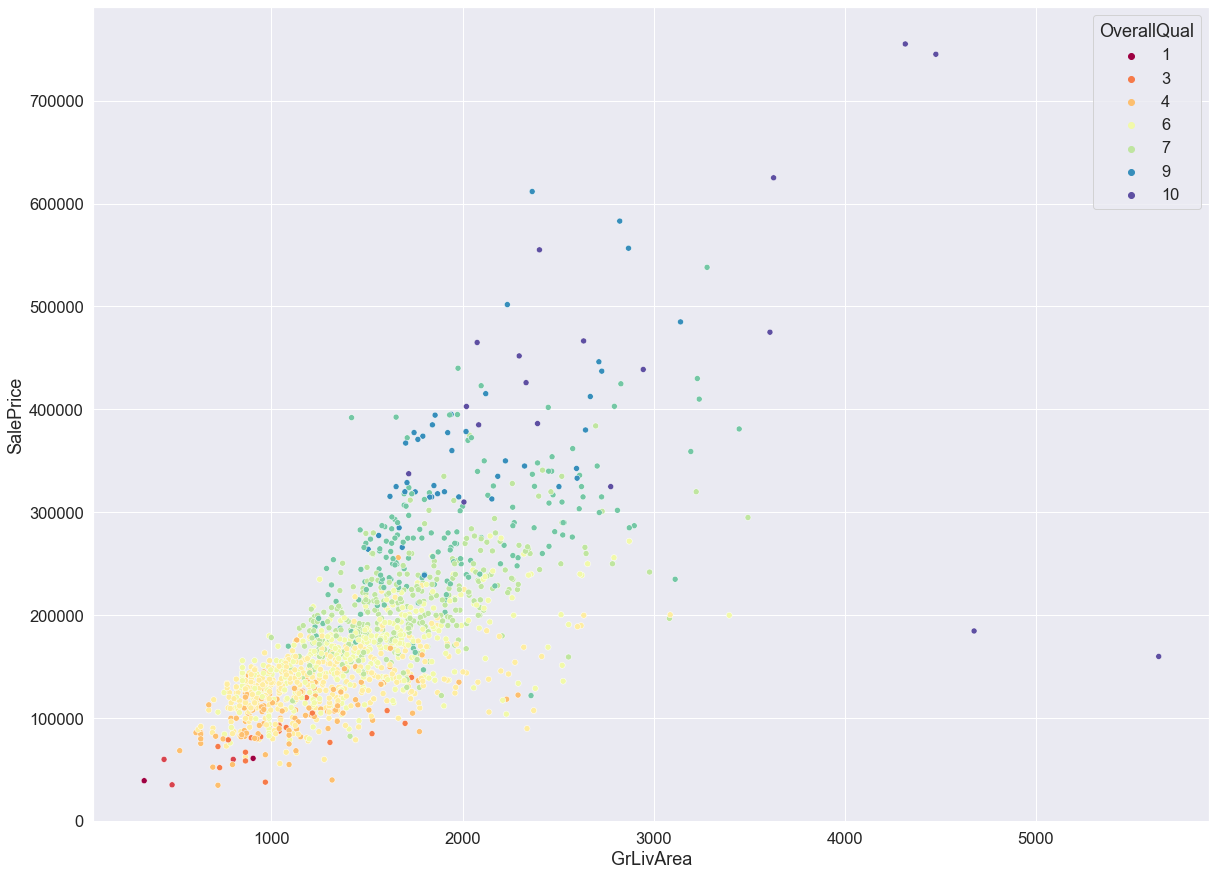

In [28]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral');